# Exercise 1: random walk

1. Write a function `randomwalk` that simulates `N` random walks for `tmax` time steps, each walk starting at zero
2. Plot all walks on the same plot
3. Plot walk endpoints on a histogram, determine how `tmax` affects the distribution

In [265]:
## 1. Define function
randomwalk <- function(N, tmax) {
  m <- matrix(nrow = N, ncol = tmax)  # Create empty matrix to store walks in
  m[,1] <- 0  # Assign first column of matrix to 0
  for (row in 1:N) {  # Loop through range of N
    for (col in 2:tmax) {  # Loop through range of tmax
      m[row, col] <- m[row, col-1] + rnorm(1)  # Insert value of x into the appropriate matrix position
    }
  }
  return(m)  # Return matrix
}

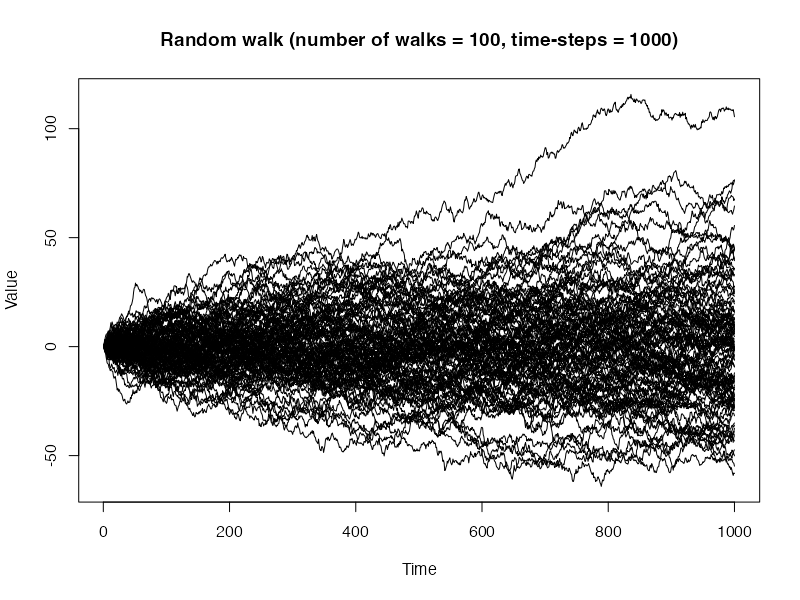

In [266]:
## 2. Plot
set.seed(0)  # Set random seed
N <- 100  # Assign N
tmax <- 1000  # Assign tmax
m <- randomwalk(N, tmax)  # Run function randomwalk to generate matrix
par(mfrow = c(1, 1))  # Force 1 subplot
plot(
  m[1,], type = "l", ylim = c(min(m), max(m)),
  main = paste0("Random walk (number of walks = ", N, ", time-steps = ", tmax, ")"), xlab = "Time", ylab = "Value"
)  # Plot the first row of the matrix using plot
for (row in 2:N) {  # Loop through the rest of the matrix rows
  points(m[row,], type = "l")  # Plot each row as a line
}

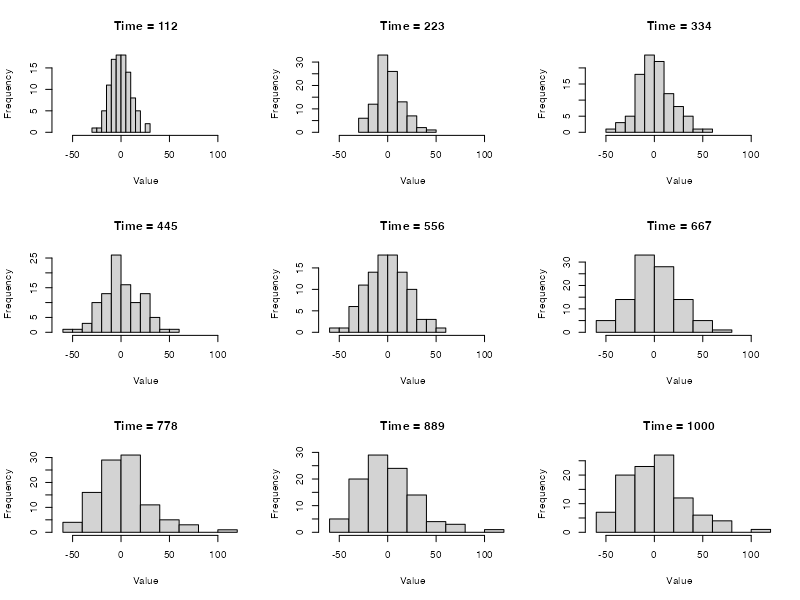

In [270]:
## 3. Plot endpoints on histogram
par(mfrow = c(3, 3))  # Force 9 subplots
t_intervals <- seq(1, tmax, length = 10)[-1]  # Get 9 evenly spaced time intervals from tmax
for (t in t_intervals) {  # Loop through time intervals
  hist(
    m[, t], xlim = c(min(m), max(m)),
    main = paste0("Time = ", t), xlab = "Value"
  )  # Plot each histogram
}

# Exercise 2: queue

Queue parameters:
- Every minute, a new customer is added to the queue with probability `P_in`
- Also every minute, a customer is finished with probability `P_out` and leaves the queue

Goal:
1. Define function `runQ` that simulates a queue for `T_queue` minutes
2. Plot the length of the queue over time

In [54]:
## 1. Define function
runQ <- function(P_in, P_out, T_queue) {
  q <- 10  # Initialize momentary queue length
  Q <- rep(q, T_queue)  # Initialize queue lenghts vector
  smpl <- function(P) {
    sample(c(0, 1), size = 1, prob = c(1-P, P))  # Define custom sample function
  }
  for (t in 2:T_queue) {  # Loop through minutes
    q <- q + (1 * smpl(P_in))  # Add one to queue with probability P_in
    if (q > 0) {  # Check that queue length is not negative
      q <- q - (1 * smpl(P_out))  # Remove one from queue with probability P_out
    }
    Q[t] <- q  # Append queue length to the queue lengths vector
  }
  return(Q)  # Return queue
}

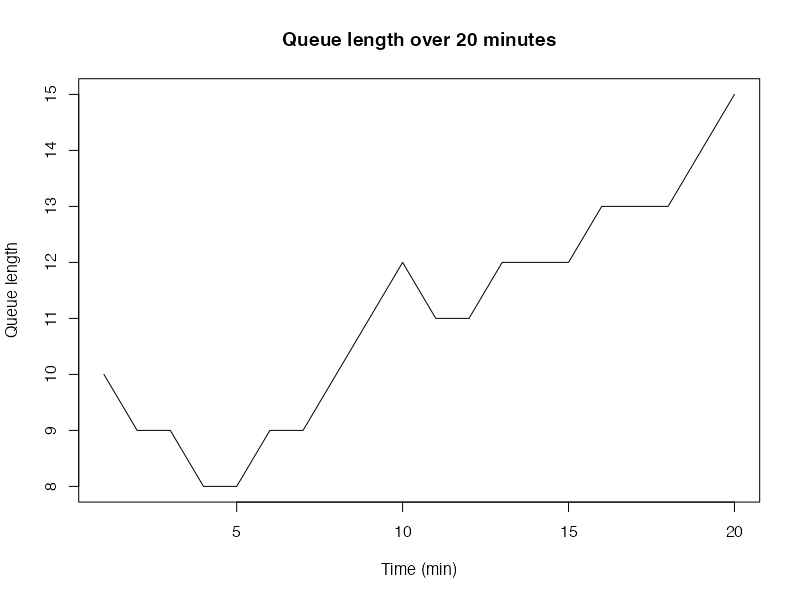

In [ ]:
## 2. Plot
set.seed(0)  # Set seed
P_in <- 0.7  # Define P_in
P_out <- 0.6  # Define P_out
T_queue <- 20  # Define T_queue
Q <- runQ(P_in, P_out, T_queue)  # Generate a vector of queue lengths
plot(
  Q, type = "l", main = paste0("Queue length over ", T_queue, " minutes"),
  xlab = "Time (min)", ylab = "Queue length"
)  # Plot the vector of queue lengths

# Exercise 3: Moran process

The moran process models the spread of an allele in a population, which has $N$ individuals of type $A$ or $B$.

Each time-step, one random individual dies and is replaced by a copy of another random individual in the population.

Goal:

1. Write a function `runMoran` that simulates the Moran process `tmax` time steps, starting with a single copy of `A`, returning the final number of `A`'s
2. Write a function `Pfixation` that uses `runMoran` to iterate the Moran process `repeats` number of times and returns the probability of fixation of A
3. Test the theoretical result that $P(fixation) = \frac{1}{N}$
4. Introduce selection such that $A$'s are more likely to reproduce than $B$'s. The weights are $1+s$ and $1$, respectively

In [210]:
## 1. Define function runMoran
runMoran <- function(tmax, popsize) {
  pop <- c("A", rep("B", popsize - 1))  # Initialize population
  for (t in 1:tmax) {  # Loop through range of tmax
    pos <- sample(seq(1, popsize), 2)  # Select dying and reproducing individual
    pop[pos[1]] <- pop[pos[2]]  # Replace dying individual with reproducing individual
    if (length(unique(pop)) < 2) {  # Check if an allele has died out
      break  # Break loop
    }
  }
  return(length(pop[pop == "A"]))  # Return final number of A's
}

In [211]:
## 2. Define function Pfixation
Pfixation <- function(n_iters, tmax, popsize) {
  freq <- 0  # Initialize vector to store fixation frequency
  for (i in 1:n_iters) {  # Loop through range of n_iters
    freq <- freq + as.logical(runMoran(tmax, popsize))  # Call runMoran and update fixation frequency
  }
  return(freq / n_iters)  # Return probability of fixation
}

In [ ]:
## 3. Evaluate 1/N against simulated probability of fixation
n_iters <- 100  # Define n_iters
tmax <- 5  # Define tmax
popsize <- 10  # Define population size
Pfix_theoretical <- 1/n_iters  # Define theoretical probability of fixation
cat(paste0(
  "Probaility of fixation when realizations = ", n_iters, " and time-steps = ", tmax, ":",
  "\nTheoretical: ", round(Pfix_theoretical*100, 1),
  "%\nSimulated: ", round(Pfixation(n_iters, tmax, popsize)*100, 1), "%"
))  # Print theoretical and simulated fixation probabilities

Probaility of fixation when realizations = 100 and time-steps = 5
Theoretical: 1%
Simulated: 57%

In [214]:
## 4. Introduce selective pressure using function runMoran_sel
runMoran_sel <- function(tmax, popsize, s) {  #Define updated runMoran function
  pop <- cbind(c(
    "A", rep("B", popsize - 1)), c(1+s, rep(1, popsize - 1)
  ))  # Initialize population matrix
  colnames(pop) <- c("Allele", "P_reprod")
  for (t in 1:tmax) {  # Loop through time steps
    d <- sample(seq(1, popsize), 1)  # Get index of dying individual
    r <- sample(
      seq(1, popsize)[-d], 1, prob = as.numeric(pop[,2])[-d]
    )  # Get index of reproducing individual
    pop[d,] <- pop[r,]  # Update population
    if (length(unique(pop[,1])) < 2) {  # Check if an allele has died out
      break  # Break loop
    }
  }
  return(length(pop[,1][pop == "A"]))  # Return final number of A's
}

In [263]:
## Bonus. Compare runMoran and runMoran_sel

## Define custom Pfixation function
Pfixation_multi <- function(n_iters, tmax, popsize, s = 0) {
  freq <- 0  # Initialize vector to store fixation frequency
  if (s == 0) {  # Call runMoran if s is neutral
    for (i in 1:n_iters) {  # Loop through range of n_iters
      freq <- freq + as.logical(
        runMoran(tmax, popsize)
      )  # Call runMoran and update fixation frequency
    }
  } else {  # Call runMoran_sel if s is not neutral
    for (i in 1:n_iters) {  # Loop through range of n_iters
      freq <- freq + as.logical(
        runMoran_sel(tmax, popsize, s)
      )  # Call runMoran and update fixation frequency
    }    
  }
  return(freq / n_iters)  # Return probability of fixation
}

## Run analysis
n_iters <- 200  # Define number of realizations
tmax <- 20  # Define number of time steps
popsize <- 10  # Define population size
s <- 20  # Define selective pressure
p_standard <- Pfixation_multi(n_iters, tmax, popsize)  # Run Pfixation on output of runMoran
p_sel <- Pfixation_multi(n_iters, tmax, popsize, s)  # Run Pfixation on output of runMoran_sel
cat(paste0("Probaility of population A surviving when realizations = ", n_iters,
  ", time-steps = ", tmax, ", and population size = ", popsize, ":",
  "\nNeutral selective pressure: ", round(p_standard*100),
  "%\nSelective pressure of ", s, ": ", round(p_sel*100), "%"))  # Print results

Probaility of population A surviving when realizations = 200, time-steps = 20, and population size = 10:
Neutral selective pressure: 32%
Selective pressure of 20: 83%